In [1]:
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pytoc import TOC, TOC_painter
import seaborn as sns
import scipy.stats as stats
import itertools
import os
import ee
from PIL import Image
import scikit_posthocs as sp

## 1. Data Preprocessing

In [2]:
# Initialize 
m = geemap.Map(center=[-31.4192, -64.19], zoom=11)
m

Map(center=[-31.4192, -64.19], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [3]:
# get current working path
cwp = os.getcwd()

In [4]:
# m.draw_features
# Load the data
roi_shp = cwp + "/data/cordoba_roi_20241204.shp"
roi = geemap.shp_to_ee(roi_shp)

# sample_shp = cwp + "/data/650sample_refine_20241123.shp"
sample_shp = cwp + "/data/20250305_615_allbands.shp"
samples = geemap.shp_to_ee(sample_shp)

m.addLayer(samples, {'color': 'red'}, "samples")
m.addLayer(roi, {}, "roi", 0)

In [5]:
# This way helps you to draw the region of interest on the map
# roi = ee.FeatureCollection(m.draw_features)
# m.addLayer(roi,{}, "roi")

In [6]:
# Add Sentinel-2 to the map
image = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(roi)
    .filterDate("2024-01-23", "2024-01-25")
    .first()
    .clip(roi)
    .divide(10000)
)

vis_params_s2 = {"min": 0.005, "max": 0.205, "bands": ["B4", "B3", "B2"]}
m.addLayer(image, vis_params_s2, "Sentinel-2")

In [11]:
# create NDBI
NDBI = image.normalizedDifference(["B11", "B8"])
m.addLayer(NDBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'NDBI')

In [12]:
# create BU
NDVI = image.normalizedDifference(["B8", "B4"])
BU = NDBI.subtract(NDVI).divide(2)
m.addLayer(BU, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'BU')

In [13]:
# create VBI
RGB = image.select('B4', 'B3', 'B2')
HSV = RGB.rgbToHsv()
VBI = HSV.normalizedDifference(["value", "saturation"])
m.addLayer(VBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'VBI')

In [9]:
# Read the extracted-value-file collected from ArcGIS Pro in that the samplings were visual inspected via ArcGIS Pro.
all_csv = pd.read_csv(cwp + "/data/20250731_615_allbands_update.csv")

# Rename BUI to BU
# all_csv.rename(columns={"BUI": "BU"}, inplace=True)

# Standardize BU
# all_csv['BU'] = all_csv['BU'] / 2

In [108]:
all_csv.head()

,Urban,Type,CID,b2,b3,b4,b8,b11,hue,sat,...,MultiBI,IBI,IBUI,BRBA,BBI,BAEI,BU,VIBI,NBAI,b12
0,1,3,0,0.1402,0.1632,0.1968,0.3300,0.3007,0.067727,0.287602,...,0.243401,0.396131,-0.015882,0.755470,1,1.070920,-0.149652,1.225090,-0.071632,0.2605
1,0,9,0,0.0624,0.0894,0.0998,0.3544,0.2026,0.120321,0.374750,...,0.091567,1.029110,-0.450288,0.720058,1,1.369178,-0.416539,1.946240,-0.187573,0.1386
2,1,4,0,0.1256,0.1632,0.1522,0.3760,0.3200,0.215426,0.230392,...,-0.111717,1.009028,-0.223364,0.634960,0,0.935844,-0.252081,1.234410,-0.143470,0.2397
3,1,1,0,0.2866,0.3596,0.4584,0.4960,0.5432,0.070819,0.374782,...,0.124842,-2.530568,0.200265,0.860522,1,0.840053,0.003011,0.464493,-0.009759,0.5327
4,1,1,0,0.4444,0.4536,0.4504,0.4764,0.3434,0.224638,0.020282,...,-0.055141,1.957983,-0.421269,1.594900,0,0.941531,-0.095144,-0.209072,-0.097475,0.2824


## 2. Spectral Signatures

In [109]:
spec_sig = all_csv.groupby('Type').agg({
    'b2': 'mean', 
    'b3': 'mean', 
    'b4': 'mean', 
    'b8': 'mean',
    'b11': 'mean',
    'b12': 'mean',
    'hue': 'mean', 
    'sat': 'mean', 
    'val': 'mean'
    }).reset_index()

In [110]:
Index_boxplot = spec_sig
Index_boxplot['Type'].replace(1, "White roof", inplace=True)
Index_boxplot['Type'].replace(2, "Red roof", inplace=True)
Index_boxplot['Type'].replace(3, "Other roof", inplace=True)
Index_boxplot['Type'].replace(4,  "Asphalt road", inplace=True)
Index_boxplot['Type'].replace(6, "Cement ground", inplace=True)
Index_boxplot['Type'].replace(7, "Vegetation", inplace=True)
Index_boxplot['Type'].replace(8, "Waterbody", inplace=True)
Index_boxplot['Type'].replace(9, "Bare soil", inplace=True)

In [111]:
Index_boxplot

,Type,b2,b3,b4,b8,b11,b12,hue,sat,val
0,White roof,0.307800,0.328276,0.337254,0.368092,0.364235,0.327484,0.230327,0.117625,0.344584
1,Red roof,0.088712,0.119194,0.182494,0.279118,0.325676,0.279541,0.055802,0.510260,0.182494
2,Other roof,0.162199,0.189010,0.206274,0.309500,0.312589,0.264294,0.125481,0.219860,0.208097
3,Asphalt road,0.115959,0.141634,0.156769,0.267421,0.298303,0.248655,0.167941,0.288320,0.158379
4,Cement ground,0.154869,0.187862,0.212600,0.321542,0.328013,0.278487,0.099912,0.271924,0.213177
5,Vegetation,0.048241,0.083961,0.070244,0.357117,0.251929,0.160565,0.236594,0.449016,0.085567
6,Waterbody,0.021708,0.050492,0.028258,0.058575,0.042642,0.024200,0.289822,0.540322,0.050492
7,Bare soil,0.087170,0.120017,0.147559,0.294155,0.319492,0.260368,0.096662,0.406596,0.147639


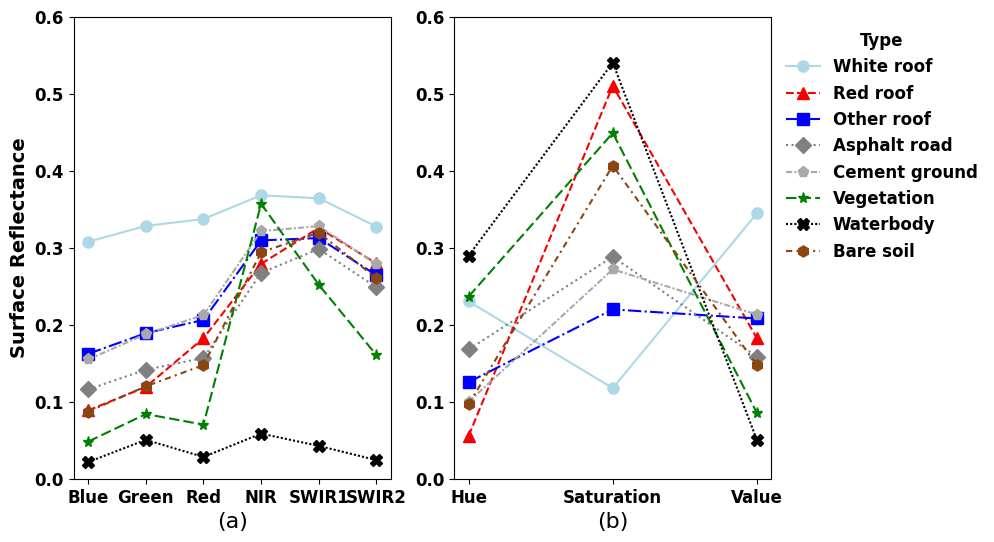

In [112]:
RGB_spec_sig = spec_sig[['Type', 'b2', 'b3', 'b4', 'b8', 'b11', 'b12']].melt(id_vars='Type', var_name='Category', value_name='Val')
HSV_spec_sig = spec_sig[['Type', 'hue', 'sat', 'val']].melt(id_vars='Type', var_name='Category', value_name='Val')


# Define the category name mapping
category_mapping_rgb = {'b2': 'Blue', 'b3': 'Green', 'b4': 'Red', 'b8': 'NIR', 'b11': 'SWIR1', 'b12': 'SWIR2'}
category_mapping_hsv = {'hue': 'Hue', 'sat': 'Saturation', 'val': 'Value'}

# Apply the mappings before melting
spec_sig_renamed = Index_boxplot.rename(columns=category_mapping_rgb | category_mapping_hsv)

# Define the desired order of categories
type_order = ['White roof', 'Red roof', 'Other roof', 'Asphalt road', 'Cement ground', 
              'Vegetation', 'Waterbody', 'Bare soil']

# Define marker styles for each category
marker_styles = {
    'White roof': 'o',   # Dots (Circle)
    'Red roof': '^',      # Triangle
    'Other roof': 's',    # Square
    'Asphalt road': 'D',  # Diamond
    'Cement ground': 'p', # Pentagon
    'Vegetation': '*',    # Star
    'Waterbody': 'X',     # Cross
    'Bare soil': 'h'      # Hexagon
}

# Define line styles for each category
line_styles = {
    'White roof': '-',    # Solid
    'Red roof': '--',     # Dashed
    'Other roof': '-.',   # Dash-dot
    'Asphalt road': ':',  # Dotted
    'Cement ground': (0, (3, 1, 1, 1)),  # Custom dashed
    'Vegetation': (0, (5, 2)),  # Long dash
    'Waterbody': (0, (1, 1)),  # Short dash
    'Bare soil': (0, (3, 2, 1, 2))  # Mixed pattern
}

spec_sig_renamed['Type'] = pd.Categorical(spec_sig_renamed['Type'], categories=type_order, ordered=True)

RGB_spec_sig = spec_sig_renamed[['Type'] + list(category_mapping_rgb.values())].melt(
    id_vars='Type', var_name='Category', value_name='Val')
HSV_spec_sig = spec_sig_renamed[['Type'] + list(category_mapping_hsv.values())].melt(
    id_vars='Type', var_name='Category', value_name='Val')

colors = {'White roof': '#ADD8E6', 'Red roof': '#F80000', 'Other roof': '#0000FF',  'Asphalt road': '#808080',  'Cement ground': '#A9A9A9',
           'Vegetation': '#008000', 'Waterbody': '#000000', 'Bare soil': '#8B4513'}

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

# Set to greyscale: color='black', markeredgecolor='black'
for category in type_order:
    subset = RGB_spec_sig[RGB_spec_sig['Type'] == category]
    axes[0].plot(subset['Category'], subset['Val'], marker=marker_styles[category], markersize = 8, linestyle=line_styles[category], label=f'{category}', color=colors[category])

for category in type_order:
    subset = HSV_spec_sig[HSV_spec_sig['Type'] == category]
    axes[1].plot(subset['Category'], subset['Val'], marker=marker_styles[category], markersize = 8, linestyle=line_styles[category], label=f'{category}', color=colors[category])
    
axes[0].set_ylim(0, 0.6)
axes[0].set_ylabel('Surface Reflectance', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 0.6)
axes[0].set_xlabel('(a)', fontsize=16)
axes[1].set_xlabel('(b)', fontsize=16)

# Increase tick label font sizes
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# axes[1].set_ylabel('surface reflectance')
# plt.ylabel('Value')
legend = axes[1].legend(title="Type", loc="upper left", bbox_to_anchor=(1, 1), fontsize=12, frameon=False)
plt.setp(legend.get_title(), fontsize=12, fontweight='bold')  # Bold legend title
for text in legend.get_texts():
    text.set_fontweight('bold')  # Bold legend labels
    
# plt.savefig("pic/Figure2_grey.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
# plt.savefig("pic/Figure2_grey.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show(); 

## 3. TOC Plot

### 3.1 Calculate AUC and threshold value

In [33]:
# Initialize TOC and generate TOC_NDBI
all_csv = all_csv.sort_values(['NDBI'], ascending=[False])
TOC_NDBI = TOC(all_csv['Urban'], all_csv['NDBI'], all_csv['NDBI'])
# Get the summary
TOC_NDBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.8080428316478286
The coordinate of point below top left corner: (205,128.0)


In [34]:
all_csv = all_csv.sort_values(['BU'], ascending=[False])
TOC_BU = TOC(all_csv['Urban'], all_csv['BU'], all_csv['BU'])

TOC_BU.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9155978584176085
The coordinate of point below top left corner: (205,154.0)


In [35]:
all_csv = all_csv.sort_values(['VBI'], ascending=[False])
TOC_VBI = TOC(all_csv['Urban'], all_csv['VBI'], all_csv['VBI'])

TOC_VBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9701606186793575
The coordinate of point below top left corner: (205,178.0)


In [19]:
# Search the minimum quantitative difference threshold
NDBI_sorted = all_csv.sort_values(['NDBI'], ascending=[False])
BU_sorted = all_csv.sort_values(['BU'], ascending=[False])
VBI_sorted = all_csv.sort_values(['VBI'], ascending=[False])

# Print out the threshold values when Misses equals to False Alarms (marked by the red star)
print(NDBI_sorted['NDBI'].iloc[204], BU_sorted['BU'].iloc[204], VBI_sorted['VBI'].iloc[204])

-0.0024038 -0.140611 -0.372807


In [20]:
# create Boolean images based on the threshold value
BoolNDBI = NDBI.expression('b(0) < -0.0024 ? 0 : b(0) >= -0.003 ? 1 : 0').clip(roi)
m.addLayer(BoolNDBI, {'palette': ['#000000', '#FFFFFF'], 'min': 0, 'max': 1}, 'Boolean NDBI')

BoolBU =BU.expression('b(0) < -0.141 ? 0 : b(0) >= -0.141 ? 1 : 0').clip(roi)
m.addLayer(BoolBU, {'palette': ['#000000', '#FFFFFF'], 'min': 0, 'max': 1}, 'Boolean BU')

BoolVBI = VBI.expression('b(0) < -0.373 ? 0 : b(0) >= -0.356 ? 1 : 0').clip(roi)
m.addLayer(BoolVBI, {'palette': ['#000000', '#FFFFFF'], 'min': 0, 'max': 1}, 'Boolean VBI')

In [21]:
# Export threshold binary images if necessary
# geemap.ee_export_image_to_drive(BoolNDBI, description = 'BoolNDBI_20250209', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BoolBUI, description = 'BoolBUI_20250209', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BoolVBI, description = 'BoolVBI_20250209', folder = 'VBI', region = roi.geometry(), scale = 10)

### 3.2 Calculate the built-up area in the study area based on the threshold value of each index

In [22]:
pixel_area = ee.Image.pixelArea()
display('Pixel area default projection', pixel_area.projection())

'Pixel area default projection'

In [23]:
nonbuiltup_mask = NDBI.gt(-0.0024038)
builtup_NDBI = pixel_area.updateMask(nonbuiltup_mask)
m.addLayer(builtup_NDBI.clip(roi), {'palette': 'yellow'}, 'builtup_NDBI')
area = builtup_NDBI.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    # crs=BoolNDBI.projection(),  # DEM coordinate reference system
    # crsTransform=BoolNDBI.projection().getInfo()['transform'],  # DEM grid alignment
    maxPixels=1e20,
);
square_meters = area.getNumber('area')
square_kilometers = square_meters.divide(1e6)
display('Square meters NDBI builtup', square_meters)
display('Square kilometers NDBI builtup', square_kilometers)

'Square meters NDBI builtup'

'Square kilometers NDBI builtup'

In [24]:
nonbuiltup_mask = BU.gt(-0.140611)
builtup_BU = pixel_area.updateMask(nonbuiltup_mask)
m.addLayer(builtup_BU.clip(roi), {'palette': 'yellow'}, 'builtup_NDBI')
area = builtup_BU.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    # crs=BoolNDBI.projection(),  # DEM coordinate reference system
    # crsTransform=BoolNDBI.projection().getInfo()['transform'],  # DEM grid alignment
    maxPixels=1e20,
);
square_meters = area.getNumber('area')
square_kilometers = square_meters.divide(1e6)
display('Square meters BU builtup', square_meters)
display('Square kilometers BU builtup', square_kilometers)

'Square meters BU builtup'

'Square kilometers BU builtup'

In [25]:
nonbuiltup_mask = VBI.gt(-0.372807)
builtup_VBI = pixel_area.updateMask(nonbuiltup_mask)
m.addLayer(builtup_VBI.clip(roi), {'palette': 'yellow'}, 'builtup_NDBI')
area = builtup_VBI.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=10,
    # crs=BoolNDBI.projection(),  # DEM coordinate reference system
    # crsTransform=BoolNDBI.projection().getInfo()['transform'],  # DEM grid alignment
    maxPixels=1e20,
);
square_meters = area.getNumber('area')
square_kilometers = square_meters.divide(1e6)
display('Square meters VBI builtup', square_meters)
display('Square kilometers VBI builtup', square_kilometers)

'Square meters VBI builtup'

'Square kilometers VBI builtup'

In [26]:
# Calculate the size of the study area
roi_geom = roi.geometry()

# Calculate area in square meters
area_m2 = roi_geom.area(1)

# Convert to square kilometers
area_km2 = area_m2.divide(1e6)

# Print the area
print("Study Area in square meters:", area_m2.getInfo())
print("Study Area in square kilometers:", area_km2.getInfo())

Study Area in square meters: 600994333.2642136
Study Area in square kilometers: 600.9943332642135


### 3.3 generate TOC plot

In [64]:
# Functions to generate TOC (code from Liu & Pontius 2021)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as matpltColors

class TOC_painter:
    def __init__(self, TOC_list=[], index_names=[], color_list=[], marker_list=[], line_list=[], boolUniform=False, boolCorrectCorner=False):
        if type(TOC_list) != list:
            self.TOC_list = [TOC_list]
        else:
            self.TOC_list = TOC_list
        if type(color_list) != list:
            self.color_list = [color_list]
        else:
            self.color_list = color_list
        if type(marker_list) != list:
            self.marker_list = [marker_list]
        else:
            self.marker_list = marker_list
        if type(line_list) != list:
            self.line_list = [line_list]
        else:
            self.line_list = line_list
        if type(index_names) != list:
            self.index_names = [index_names]
        else:
            self.index_names = index_names

        self.totalNum = 0
        self.presenceInY = 0
        self.TOCNum = 0
        self.curve_list = []
        if len(self.TOC_list) > 0:
            if len(self.index_names) == 0:
                self.index_names = ["TOC{0}".format(i + 1) for i in range(len(self.TOC_list))]
            if len(self.color_list) == 0:
                self.color_list = ["" for _ in range(len(self.TOC_list))]
            if len(self.marker_list) == 0:
                self.marker_list = ["" for _ in range(len(self.TOC_list))]
            if len(self.line_list) == 0:
                self.line_list = ["-" for _ in range(len(self.TOC_list))]
            for i in range(len(self.TOC_list)):
                item_dic = {
                    'TOCX': self.TOC_list[i].TOCX,
                    'TOCY': self.TOC_list[i].TOCY,
                    'threshold': self.TOC_list[i].thresholdLabel,
                    'color': self.color_list[i],
                    'marker': self.marker_list[i],
                    'line': self.line_list[i],
                    'name': self.index_names[i]
                }
                self.curve_list.append(item_dic)
            self.__update_status()

        self.boolUniform = boolUniform
        self.boolCorrectCorner = boolCorrectCorner
        self.fig, self.ax = plt.subplots()

    def __update_status(self):
        self.TOCNum = len(self.curve_list)
        if self.TOCNum > 0:
            self.totalNum = self.curve_list[0]['TOCX'][0, -1]
            self.presenceInY = self.curve_list[0]['TOCY'][0, -1]

    def __addOne(self, index):
        Xlist = self.curve_list[index]['TOCX']
        Ylist = self.curve_list[index]['TOCY']
        color = self.curve_list[index]['color']
        marker = self.curve_list[index]['marker']
        line = self.curve_list[index]['line']
        Name = self.curve_list[index]['name']
        symbol = marker + line
        if len(color) == 0:
            plt.plot(Xlist[0, :], Ylist[0, :], symbol, label=Name, clip_on=False)
        else:
            plt.plot(Xlist[0, :], Ylist[0, :], symbol, color=color, label=Name, clip_on=False)
        handles, labels = plt.gca().get_legend_handles_labels()
        numCurve = len(handles)
        if labels[0] == 'Uniform':
            order = list(range(1, numCurve))
            order.extend([0])
        else:
            order = list(range(0, numCurve))
        plt.gca().legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='center left', bbox_to_anchor=(1, 0.5))

    def __format_coordinates(self, TOCX, TOCY):
        TOCX = np.array(TOCX).flatten()
        TOCX = TOCX.reshape((1, TOCX.shape[0]))
        TOCY = np.array(TOCY).flatten()
        TOCY = TOCY.reshape((1, TOCY.shape[0]))
        return TOCX, TOCY

    def add_correct_corner(self, index):
        TOCX = self.curve_list[index]['TOCX']
        TOCY = self.curve_list[index]['TOCY']
        presenceInY = TOCY[0, -1]
        bool_presence = (TOCX <= presenceInY).astype(int)
        corner_index = bool_presence.sum() - 1
        if corner_index == TOCY.shape[1] - 1:
            y_res = TOCX[0, -1]
        else:
            y_res = (TOCY[0, corner_index + 1] - TOCY[0, corner_index]) * 1.0 / (
                        TOCX[0, corner_index + 1] - TOCX[0, corner_index]) * (presenceInY - TOCX[0, corner_index]) + TOCY[0, corner_index] * 1.0
        plt.plot(presenceInY, y_res, 'r*', zorder=20)

    def add_all_correct_corner(self):
        for i in range(self.TOCNum):
            self.add_correct_corner(i)

    def add_TOC(self, TOC, index_name=None, color='', marker='', line='-'):
        self.__update_status()
        if index_name is None:
            index_list = [j['name'] for j in self.curve_list]
            for i in range(1, self.TOCNum + 2):
                if 'TOC' + str(i) not in index_list:
                    index_name = 'TOC' + str(i)
                    break
        item_dic = {
            'TOCX': TOC.TOCX,
            'TOCY': TOC.TOCY,
            'threshold': TOC.thresholdLabel,
            'color': color,
            'marker': marker,
            'line': line,
            'name': index_name
        }
        self.curve_list.append(item_dic)
        self.__update_status()

    def add_TOC_coor(self, TOCX, TOCY, threshold=[], index_name=None, color='', marker='', line='-'):
        self.__update_status()
        if index_name is None:
            index_list = [j['name'] for j in self.curve_list]
            for i in range(1, self.TOCNum + 2):
                if 'TOC' + str(i) not in index_list:
                    index_name = 'TOC' + str(i)
                    break
        TOCX, TOCY = self.__format_coordinates(TOCX, TOCY)
        item_dic = {
            'TOCX': TOCX,
            'TOCY': TOCY,
            'threshold': threshold,
            'color': color,
            'marker': marker,
            'line': line,
            'name': index_name
        }
        self.curve_list.append(item_dic)
        self.__update_status()

    def paint(self):
        self.__update_status()
        cmap = matpltColors.ListedColormap(['#e0e0e0'])

        # Define vertices for the triangles
        vertices = np.array([[self.totalNum - self.presenceInY, 0],
                             [self.totalNum, 0],
                             [self.totalNum, self.presenceInY],
                             [0, 0],
                             [0, self.presenceInY],
                             [self.presenceInY, self.presenceInY]])

        # Define the triangles using vertex indices
        triangles = np.array([[0, 1, 2],
                              [3, 4, 5]])

        # Define the face colors, one for each triangle
        facecolors = np.array([1, 1])  # Array length must match the number of triangles

        plt.tripcolor(vertices[:, 0], vertices[:, 1], triangles, facecolors=facecolors, edgecolor="k", lw=0, cmap=cmap)

        plt.axis('square')
        plt.axis([0, self.totalNum, 0, self.presenceInY])
        plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
        if self.boolCorrectCorner:
            plt.text(0, self.presenceInY * 1.01, 'The red star marks where False Alarms equals Misses.', color="black", fontsize=8)
        if self.boolUniform:
            plt.plot([0, self.totalNum], [0, self.presenceInY], ':', color="violet", label='Uniform')
        
        for i in range(self.TOCNum):
            self.__addOne(i)
        plt.savefig("pic/Figure10.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
        plt.savefig("pic/Figure10.pdf", dpi=1200, format="pdf", bbox_inches="tight")
        plt.show()


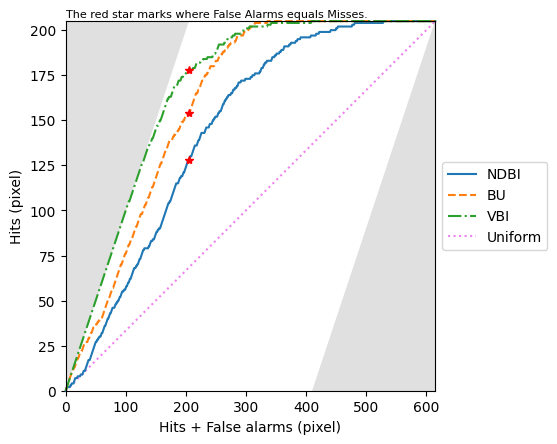

In [28]:
# Assuming TOC_NDBI, TOC_BUI, TOC_VBI are instances of the TOC class with the necessary attributes
TOC_list = [TOC_NDBI, TOC_BU, TOC_VBI]
index_names = ["NDBI", "BU", "VBI"]

# Define custom colors, markers, and line styles for each index
line_list = ['-', '--', '-.']  # Solid (NDBI), Dashed (BU), Dash-dot (VBI)

toc_painter = TOC_painter(
    TOC_list=TOC_list, 
    index_names=index_names, 
    line_list = line_list,
    boolUniform=True, 
    boolCorrectCorner=True)
plt.xlabel('Hits + False alarms (pixel)')
plt.ylabel('Hits (pixel)')
toc_painter.add_all_correct_corner()
toc_painter.paint()

In [29]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure4.jpg").convert("L")
img.save("pic/Figure4_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure4_greyscale.jpg")  # Overwrite with grayscale version

## 4. Boxplot Generation

In [30]:
# generate the boxplot and the 2 SD difference plot
Index_boxplot = all_csv
Index_boxplot['Type'].replace(1, "White", inplace=True)
Index_boxplot['Type'].replace(2, "Red", inplace=True)
Index_boxplot['Type'].replace(3, "Other", inplace=True)
Index_boxplot['Type'].replace(4, "Road", inplace=True)
Index_boxplot['Type'].replace(6, "Ground", inplace=True)
Index_boxplot['Type'].replace(7, "Vegetation", inplace=True)
Index_boxplot['Type'].replace(8, "Water", inplace=True)
Index_boxplot['Type'].replace(9, "Soil", inplace=True)

Index_boxplot['Urban'].replace(0, "Non-Built-up", inplace=True)
Index_boxplot['Urban'].replace(1, "Built-up", inplace=True)

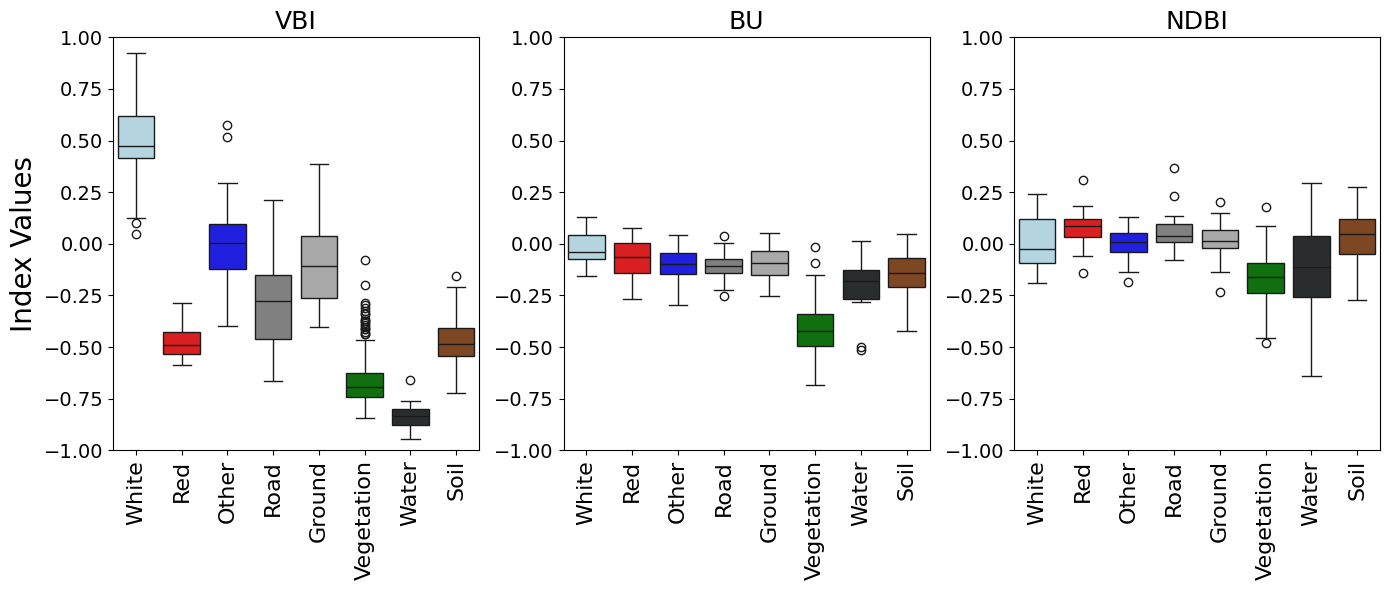

In [31]:
palette = {'White': '#ADD8E6', 'Red': '#F80000', 'Other': '#0000FF',  'Road': '#808080',  'Ground': '#A9A9A9',
           'Vegetation': '#008000', 'Water': '#2a2d2d', 'Soil': '#8B4513'}
bp_order = ['White', 'Red', 'Other', 'Road', 'Ground', 'Vegetation', 'Water', 'Soil']

# Define font sizes
axis_fontsize = 20  # Font size for labels
title_fontsize = 18  # Font size for titles
tick_fontsize = 14  # Font size for tick labels
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(ax=axes[0], x='Type', y='VBI', data=Index_boxplot, palette=palette, 
            order=bp_order)
axes[0].set_ylim(-1, 1)
axes[0].set_title('VBI', fontsize=title_fontsize)
axes[0].set_xlabel('')
axes[0].set_ylabel('Index Values', fontsize=axis_fontsize)
axes[0].tick_params(axis='x', labelrotation=90, labelsize=16)  # Adjust tick font size
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[1], x='Type', y='BU', data=Index_boxplot, palette=palette, 
            order=bp_order)
axes[1].set_ylim(-1, 1)
axes[1].set_title('BU', fontsize=title_fontsize)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelrotation=90, labelsize=16)  # Adjust tick font size
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[2], x='Type', y='NDBI', data=Index_boxplot, palette=palette, 
            order=bp_order)
axes[2].set_ylim(-1, 1)
axes[2].set_title('NDBI', fontsize=title_fontsize)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='x', labelrotation=90, labelsize=16)  # Adjust tick font size
axes[2].tick_params(axis='y', labelsize=tick_fontsize)

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig("pic/Figure8.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
plt.savefig("pic/Figure8.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

In [32]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure8.jpg").convert("L")
img.save("pic/Figure8_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure8_greyscale.jpg")  # Overwrite with grayscale version

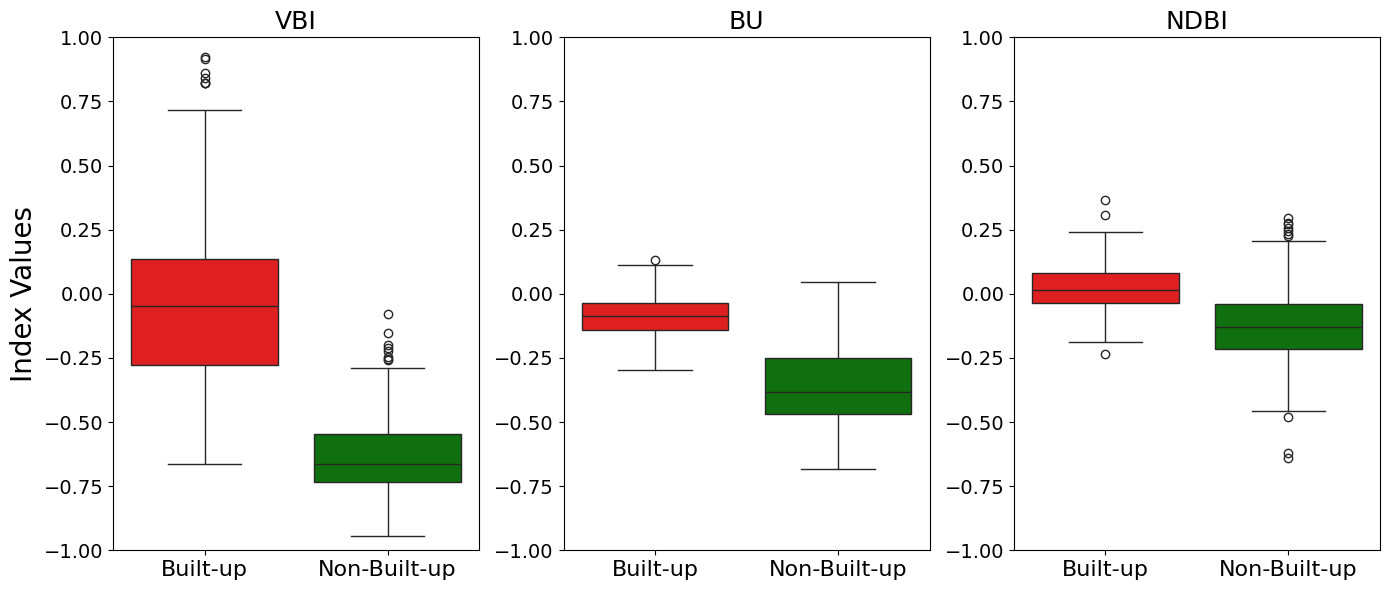

In [33]:
palette = {'Built-up': 'red', 'Non-Built-up': 'green'}
bp_order = ['Built-up', 'Non-Built-up']
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Define font sizes
axis_fontsize = 20  # Font size for labels
title_fontsize = 18  # Font size for titles
tick_fontsize = 14  # Font size for tick labels

sns.boxplot(ax=axes[0], x='Urban', y='VBI', data=Index_boxplot, palette=palette, order=bp_order)
axes[0].set_ylim(-1, 1)
axes[0].set_title('VBI', fontsize=title_fontsize)
axes[0].set_xlabel('')
axes[0].set_ylabel('Index Values', fontsize=axis_fontsize)
axes[0].tick_params(axis='both', labelsize=16)  # Adjust tick font size
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[1], x='Urban', y='BU', data=Index_boxplot, palette=palette, order=bp_order)
axes[1].set_ylim(-1, 1)
axes[1].set_title('BU', fontsize=title_fontsize)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', labelsize=16)  # Adjust tick font size
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

sns.boxplot(ax=axes[2], x='Urban', y='NDBI', data=Index_boxplot, palette=palette, order=bp_order)
axes[2].set_ylim(-1, 1)
axes[2].set_title('NDBI', fontsize=title_fontsize)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='both', labelsize=16)  # Adjust tick font size
axes[2].tick_params(axis='y', labelsize=tick_fontsize)

plt.tight_layout()  # Adjust subplots to fit into the figure area
# plt.savefig("pic/Figure7.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
# plt.savefig("pic/Figure7.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

In [34]:
# Open the saved image and convert it to grayscale
# img = Image.open("pic/Figure7.jpg").convert("L")
# img.save("pic/Figure7_greyscale.pdf")  # Overwrite with grayscale version
# img.save("pic/Figure7_greyscale.jpg")  # Overwrite with grayscale version

## 5. Statistical Importance Analysis

In [50]:
# Load all_csv again to avoid errors
all_csv = pd.read_csv(cwp + "/data/20250731_615_allbands_update.csv")
# Rename BUI to BU
all_csv.rename(columns={"BUI": "BU"}, inplace=True)
# Standardize BU
all_csv['BU'] = all_csv['BU'] / 2

In [51]:
# Perform Mann-Whitney U Test for Urban vs. Non-Urban for VBI, BUI, and NDBI
urban_vbi = all_csv[all_csv['Urban'] == 1]['VBI']
non_urban_vbi = all_csv[all_csv['Urban'] == 0]['VBI']

urban_bui = all_csv[all_csv['Urban'] == 1]['BU']
non_urban_bui = all_csv[all_csv['Urban'] == 0]['BU']

urban_ndbi = all_csv[all_csv['Urban'] == 1]['NDBI']
non_urban_ndbi = all_csv[all_csv['Urban'] == 0]['NDBI']

# Perform Mann-Whitney U Test for each index
vbi_stat, vbi_p = stats.mannwhitneyu(urban_vbi, non_urban_vbi, alternative='two-sided')
bui_stat, bui_p = stats.mannwhitneyu(urban_bui, non_urban_bui, alternative='two-sided')
ndbi_stat, ndbi_p = stats.mannwhitneyu(urban_ndbi, non_urban_ndbi, alternative='two-sided')

# Store results in a dictionary
mann_whitney_results = {
    "VBI": {"Statistic": vbi_stat, "P-value": vbi_p},
    "BU": {"Statistic": bui_stat, "P-value": bui_p},
    "NDBI": {"Statistic": ndbi_stat, "P-value": ndbi_p}
}

# Interpretation
for metric, result in mann_whitney_results.items():
    result["Conclusion"] = "Significant difference" if result["P-value"] < 0.05 else "No significant difference"

# Display results
mann_whitney_results


{'VBI': {'Statistic': 81542.0,
  'P-value': 1.0720382020781756e-80,
  'Conclusion': 'Significant difference'},
 'BU': {'Statistic': 76956.0,
  'P-value': 1.8468403024225138e-63,
  'Conclusion': 'Significant difference'},
 'NDBI': {'Statistic': 67916.0,
  'P-value': 1.1672749871559839e-35,
  'Conclusion': 'Significant difference'}}

In [52]:
# Since normality and homogeneity assumptions are violated for VBI and BU, ANOVA might not be fully reliable.
# Recommended Alternative: Use the Kruskal-Wallis Test (Non-Parametric ANOVA) for these variables.
# Use Dunn’s Post-Hoc Test for multi-groups comparisons.

# 1. Run Kruskal-Wallis test

variables = ['VBI', 'BU', 'NDBI']

# Dictionary to store results
kruskal_results_land_cover = {}

# Perform Kruskal-Wallis Test for each variable across land cover types
for variable in variables:
    groups = [all_csv[all_csv['Type'] == t][variable].dropna() for t in all_csv['Type'].unique()]
    kruskal_stat, p_value = stats.kruskal(*groups)
    
    # Store results
    kruskal_results_land_cover[variable] = {
        "Kruskal-Wallis Statistic": kruskal_stat,
        "P-value": p_value
    }

    # Interpretation
    if p_value < 0.05:
        kruskal_results_land_cover[variable]["Conclusion"] = f"There is a significant difference in {variable} among the 8 land cover types."
    else:
        kruskal_results_land_cover[variable]["Conclusion"] = f"No significant difference in {variable} among the 8 land cover types."

# Print the results
for variable, result in kruskal_results_land_cover.items():
    print(f"\n{variable} Kruskal-Wallis Test Results:")
    print(f"Statistic: {result['Kruskal-Wallis Statistic']:.4f}, P-value: {result['P-value']:.4e}")
    print(f"Conclusion: {result['Conclusion']}")




VBI Kruskal-Wallis Test Results:
Statistic: 466.0585, P-value: 1.5787e-96
Conclusion: There is a significant difference in VBI among the 8 land cover types.

BU Kruskal-Wallis Test Results:
Statistic: 431.6037, P-value: 3.9540e-89
Conclusion: There is a significant difference in BU among the 8 land cover types.

NDBI Kruskal-Wallis Test Results:
Statistic: 310.7053, P-value: 3.1255e-63
Conclusion: There is a significant difference in NDBI among the 8 land cover types.


In [53]:
# Perform Dunn's test with Bonferroni correction for multiple comparisons
dunn_results_bu = sp.posthoc_dunn(all_csv, val_col='BU', group_col='Type', p_adjust='bonferroni')
dunn_results_ndbi = sp.posthoc_dunn(all_csv, val_col='NDBI', group_col='Type', p_adjust='bonferroni')
dunn_results_vbi = sp.posthoc_dunn(all_csv, val_col='VBI', group_col='Type', p_adjust='bonferroni')

dunn_results_vbi

,1,2,3,4,6,7,8,9
1,1.000000e+00,0.000169,1.000000e+00,9.137711e-03,2.991581e-01,1.441390e-39,1.289640e-19,1.613251e-10
2,1.685241e-04,1.000000,2.156170e-02,1.000000e+00,1.516866e-01,1.486918e-03,4.885055e-05,1.000000e+00
3,1.000000e+00,0.021562,1.000000e+00,8.858635e-01,1.000000e+00,4.547885e-46,1.107649e-16,1.626140e-07
4,9.137711e-03,1.000000,8.858635e-01,1.000000e+00,1.000000e+00,3.190961e-12,1.988371e-09,9.094052e-01
6,2.991581e-01,0.151687,1.000000e+00,1.000000e+00,1.000000e+00,3.197303e-31,2.229801e-14,1.340240e-04
7,1.441390e-39,0.001487,4.547885e-46,3.190961e-12,3.197303e-31,1.000000e+00,1.911992e-01,1.070919e-14
8,1.289640e-19,0.000049,1.107649e-16,1.988371e-09,2.229801e-14,1.911992e-01,1.000000e+00,2.056469e-07
9,1.613251e-10,1.000000,1.626140e-07,9.094052e-01,1.340240e-04,1.070919e-14,2.056469e-07,1.000000e+00


In [54]:
# Function to convert a square matrix into a lower triangular format with NaNs
def make_lower_triangular(df):
    matrix = df.copy()
    mask = np.triu(np.ones(matrix.shape), k=1)  # Create upper triangular mask
    matrix = matrix.mask(mask == 1, np.nan)  # Apply NaN to upper triangle
    return matrix

# Assuming the data is similar to Dunn's test output, process it into a lower triangular format
triangular_ndbi = make_lower_triangular(dunn_results_ndbi)
triangular_bu = make_lower_triangular(dunn_results_bu)
triangular_vbi = make_lower_triangular(dunn_results_vbi)

In [55]:
triangular_ndbi

,1,2,3,4,6,7,8,9
1,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN
4,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN
6,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,NaN
7,5.012844e-11,1.351353e-10,1.489123e-22,6.038058e-16,4.068257e-18,1.000000e+00,NaN,NaN
8,6.541807e-01,2.601040e-02,1.591056e-01,1.737869e-02,1.633089e-01,1.000000e+00,1.000000,NaN
9,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.709779e-33,0.029978,1.0


In [56]:
# Define a mapping of numbers to labels
rename_dict = {
    1: "White",
    2: "Red",
    3: "Other",
    4: "Road",
    6: "Ground",
    7: "Vegetation",
    8: "Water",
    9: "Soil"
}

# Rename the index and columns of the triangular NDBI, BU, and VBI matrix
triangular_ndbi_renamed = triangular_ndbi.rename(index=rename_dict, columns=rename_dict)
triangular_bu_renamed = triangular_bu.rename(index=rename_dict, columns=rename_dict)
triangular_vbi_renamed = triangular_vbi.rename(index=rename_dict, columns=rename_dict)

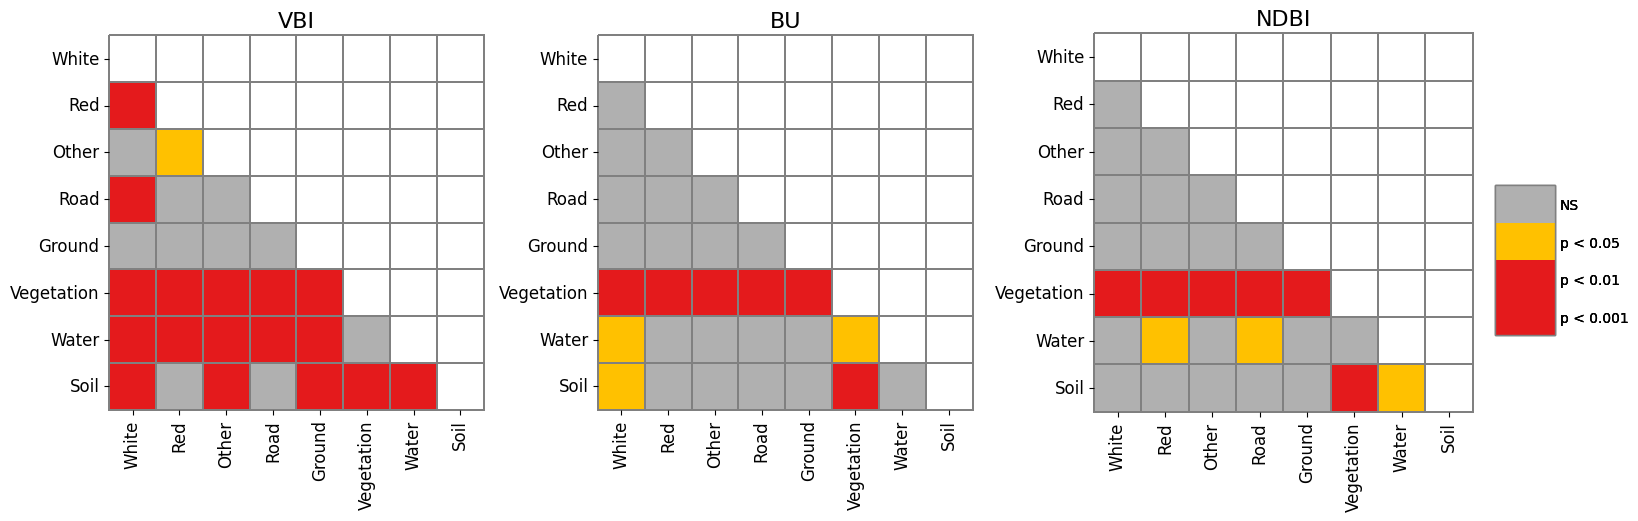

In [57]:
cmap = ['1', '#B0B0B0',  '#E41A1C',  '#E41A1C', '#ffc100']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [1, 0.35, 0.04, 0.3], 'cbar_kws': {'shrink': 0.8, 'labelsize': 16}}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.05]})  

sp.sign_plot(triangular_ndbi_renamed, ax=axes[2], **heatmap_args)
axes[2].set_title("NDBI", fontsize=16)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)

sp.sign_plot(triangular_bu_renamed, ax=axes[1], **heatmap_args)
axes[1].set_title("BU", fontsize=16)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

sp.sign_plot(triangular_vbi_renamed, ax=axes[0], **heatmap_args)
axes[0].set_title("VBI", fontsize=16)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Adjust the figure layout and add a colorbar outside the plots
# cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])  # [x-position, y-position, width, height]
# fig.colorbar(im.collections[0], cax=cbar_ax)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("pic/Figure9.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
# plt.savefig("Figure9.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()

# Compare with other existing BIs

# Comparing Different Existing Built-up Indices with VBI

1. <a href="https://www.tandfonline.com/doi/full/10.1080/01431161.2012.687842">VIBI (2012)</a> 
2. <a href="https://www.tandfonline.com/doi/full/10.1080/01431160802039957">IBI (2008)</a>
3. <a href="https://www.tandfonline.com/doi/abs/10.1080/2150704X.2014.973996">BBI (2014)</a>
4. <a href="https://link.springer.com/article/10.1007/s12517-020-06183-z"> IBUI (2020)</a>
5. <a href="https://link.springer.com/article/10.1007/s12524-015-0460-6">BAEI (2015)</a>
6. <a href="https://www.researchgate.net/publication/284816904_Development_of_new_indices_for_extraction_of_built-up_area_and_bare_soil_from_landsat">NBAI (2012)</a>
7. <a href="https://www.researchgate.net/publication/284816904_Development_of_new_indices_for_extraction_of_built-up_area_and_bare_soil_from_landsat">BRBA (2012)</a>
8. <a href="https://ieeexplore.ieee.org/abstract/document/5567823">NBI (2010)</a>
9. <a href="https://www.tandfonline.com/doi/abs/10.1080/01431160304987">NDBI (2002)</a>
10. <a href="https://www.tandfonline.com/doi/full/10.1080/01431161.2010.481681">BU (2008)</a>
11. <a href="https://www.mdpi.com/2072-4292/11/3/345">MultiBI (2019)</a>

## 1. Index Formula
1. VIBI = NDVI / (NDVI + NDBI)
2. IBI = [NDBI - (SAVI + MNDWI) / 2] / [NDBI + (SAVI + MNDWI) / 2]
3. BBI = NDBI(OLI2 - OLI3, b) + NDBI(OLI14 - OLI3, b)
4. IBUI = NDBI - SAVI - MNDWI
5. BAEI = (RED + 0.3) / (GREEN + SWIR1)
6. NBAI = [SWIR2 - SWIR1 / GREEN] / [SWIR2 + SWIR1 / GREEN]
7. BRBA = RED / SWIR2
8. NBI = RED * SWIR2 / NIR
9. NDBI = (SWIR1 - NIR) / (SWIR1 + NIR)
10. BU = NDBI - NDVI
11. MultiBI = NDTI + NDVIre + MNDWI 

In [14]:
# Create MBI
VIBI = image.expression(
    '(NDVI) / (NDVI + NDBI)',
    {
        'NDVI': NDVI,
        'NDBI': NDBI
    }
)
m.addLayer(VIBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'VIBI')

In [15]:
# Create other indices
# Create IBI
L = 0.5  # Soil adjustment factor for SAVI
SAVI = image.select().expression(
    '(NIR - RED) / (NIR + RED + L) * (1 + L)',
    {
        'NIR': image.select('B8'),
        'RED': image.select('B4'),
        'L': L
    }
)
MNDWI = image.normalizedDifference(["B3", "B11"])
IBI = image.expression(
    '(NDBI - ((SAVI + MNDWI) / 2)) / (NDBI + ((SAVI + MNDWI) / 2))',
    {
        'NDBI': NDBI,
        'SAVI': SAVI,
        'MNDWI': MNDWI
    })
m.addLayer(IBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'IBI')

In [16]:
# Create BBI
ndbi_2_3 = image.normalizedDifference(['B2', 'B3']).rename('NDBI_2_3')
ndbi_4_3 = image.normalizedDifference(['B4', 'B3']).rename('NDBI_4_3')

ndbi_2_3_b = ndbi_2_3.gt(0).rename('NDBI_2_3_b')
ndbi_4_3_b = ndbi_4_3.gt(0).rename('NDBI_4_3_b')

BBI = ndbi_2_3_b.add(ndbi_4_3_b)
m.addLayer(BBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'BBI')

In [17]:
# Create IBUI
IBUI = image.expression(
    'NDBI - SAVI - MNDWI',
    {
        'NDBI': NDBI,
        'SAVI': SAVI,
        'MNDWI': MNDWI
    }
)
m.addLayer(IBUI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'IBUI')

In [18]:
# Create BAEI
BAEI = image. expression(
    '(R + 0.3) / (G + SWIR)',
    {
        'R': image.select('B4'),
        'G': image.select('B3'),
        'SWIR': image.select('B11'),
    }
)
m.addLayer(BAEI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'BAEI')

In [19]:
# Create NBAI
NBAI = image.expression(
    '(SWIR2 - SWIR1 / G) / (SWIR2 + SWIR1 / G)',
    {
        'SWIR2': image.select('B12'),
        'SWIR1': image.select('B11'),
        'G': image.select('B3')
    }
)
m.addLayer(NBAI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'NBAI')

In [20]:
# Create BRBA
BRBA = image.select('B4').divide(image.select('B12'))
m.addLayer(BRBA, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'BRBA')

In [21]:
# Create NBI
NBI = image.expression(
    'R * SWIR2 / NIR',
    {
        'R': image.select('B4'),
        'SWIR2': image.select('B12'),
        'NIR': image.select('B8')
    }
)
m.addLayer(NBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'NBI')

In [22]:
# Create NDTI + NDVIre + MNDWI 
NDTI = image.normalizedDifference(['B11', 'B12'])
NDVIre = image.normalizedDifference(['B5', 'B4'])
MultiBI = NDTI.add(NDVIre).add(MNDWI).multiply(-1)
m.addLayer(MultiBI, {'palette': ['#000000', '#FFFFFF'], 'min': -1, 'max': 1}, 'MultiBI')

In [54]:
# # Extract values to points (same data have been collected via ArcIS Pro and stored in the data folder)
# work_dir = cwp + "/data/"
# in_shp = os.path.join(work_dir, "20250305_615_allbands.shp")
# in_fc = geemap.shp_to_ee(in_shp)

# VIBI_csv = os.path.join(work_dir, "VIBI615.csv")
# IBI_csv = os.path.join(work_dir, "IBI615.csv")
# BBI_csv = os.path.join(work_dir, "BBI615.csv")
# IBUI_csv = os.path.join(work_dir, "IBUI615.csv")
# BAEI_csv = os.path.join(work_dir, "BAEI615.csv")
# NBAI_csv = os.path.join(work_dir, "NBAI615.csv")
# BRBA_csv = os.path.join(work_dir, "BRBA615.csv")
# NBI_csv = os.path.join(work_dir, "NBI615.csv")
# NDBI_csv = os.path.join(work_dir, "NDBI615.csv") 
# BU_csv = os.path.join(work_dir, "BUI615.csv")
# multiBI_csv = os.path.join(work_dir, "MultiBI615.csv")
# VBI_csv = os.path.join(work_dir, "VBI615.csv")


# geemap.extract_values_to_points(in_fc, VIBI, VIBI_csv)
# geemap.extract_values_to_points(in_fc, IBI, IBI_csv)
# geemap.extract_values_to_points(in_fc, BBI, BBI_csv)
# geemap.extract_values_to_points(in_fc, IBUI, IBUI_csv)
# geemap.extract_values_to_points(in_fc, BAEI, BAEI_csv)
# geemap.extract_values_to_points(in_fc, NBAI, NBAI_csv)
# geemap.extract_values_to_points(in_fc, BRBA, BRBA_csv)
# geemap.extract_values_to_points(in_fc, NBI, NBI_csv)
# geemap.extract_values_to_points(in_fc, NDBI, NDBI_csv)
# geemap.extract_values_to_points(in_fc, BU, BU_csv)
# geemap.extract_values_to_points(in_fc, MultiBI, multiBI_csv)
# geemap.extract_values_to_points(in_fc, VBI, VBI_csv)


# RGB_csv = os.path.join(work_dir, "RGB615.csv")
# HSV_csv = os.path.join(work_dir, "HSV615.csv")
# geemap.extract_values_to_points(in_fc, RGB, RGB_csv)
# geemap.extract_values_to_points(in_fc, HSV, HSV_csv)

Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\VIBI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\IBI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\BBI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\IBUI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\BAEI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\NBAI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\BRBA615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\NBI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github_page\VBI\data\NDBI615.csv
Generating URL ...
Please wait ...
Data downloaded to C:\clark\GitHub\github

In [8]:
# # Export images if necessary
# geemap.ee_export_image_to_drive(VIBI, description = 'VIBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(IBI, description = 'IBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BBI, description = 'BBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(IBUI, description = 'IBUI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BAEI, description = 'BAEI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BRBA, description = 'BRBA_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(NBI, description = 'NBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(NBAI, description = 'NBAI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(NDBI, description = 'NDBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(BU, description = 'BUI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(VBI, description = 'VBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)
# geemap.ee_export_image_to_drive(MultiBI, description = 'MultiBI_20250731', folder = 'VBI', region = roi.geometry(), scale = 10)

In [56]:
# Read your CSVs
# Since the sample points were visual inspected by ArcGIS Pro, we extracted the values to points by
# ArcGIS pro as well to keep it consistent and skip the following steps.
# vibi = pd.read_csv(work_dir + "VIBI615.csv")
# ibi = pd.read_csv(work_dir + "IBI615.csv")
# bbi = pd.read_csv(work_dir + "BBI615.csv")
# ibui = pd.read_csv(work_dir + "IBUI615.csv")
# baei = pd.read_csv(work_dir + "BAEI615.csv")
# brba = pd.read_csv(work_dir + "BRBA615.csv")
# nbi = pd.read_csv(work_dir + "NBI615.csv")
# nbai = pd.read_csv(work_dir + "NBAI615.csv")
# ndbi = pd.read_csv(work_dir + "NDBI615.csv")
# bu = pd.read_csv(work_dir + "BUI615.csv")
# vbi = pd.read_csv(work_dir + "VBI615.csv")
# multibi = pd.read_csv(work_dir + "MultiBI615.csv")

# # Keep only the needed columns and rename 'first'
# vibi = vibi[['first']].rename(columns={'first': 'VIBI'})
# ibi = ibi[['first']].rename(columns={'first': 'IBI'})
# bbi = bbi[['first']].rename(columns={'first': 'BBI'})
# ibui = ibui[['first']].rename(columns={'first': 'IBUI'})
# baei = baei[['first']].rename(columns={'first': 'BAEI'})
# brba = brba[['first']].rename(columns={'first': 'BRBA'})
# nbi = nbi[['first']].rename(columns={'first': 'NBI'})
# nbai = nbai[['first']].rename(columns={'first': 'NBAI'})
# ndbi = ndbi[['first', 'Urban', 'Type']].rename(columns={'first': 'NDBI'})
# bu = bu[['first']].rename(columns={'first': 'BU'})   # Urban & Type already in NDBI
# vbi = vbi[['first']].rename(columns={'first': 'VBI'})
# multibi = multibi[['first']].rename(columns={'first': 'MultiBI'})

# # Combine into one dataframe
# merged = pd.concat([vibi, ibi, bbi, ibui, baei, brba, nbi, nbai, ndbi, bu, vbi, multibi], axis=1)

# # Save to CSV
# merged.to_csv("Combined_Builtup_Index.csv", index=False)

# merged.head()


,VIBI,IBI,BBI,IBUI,BAEI,BRBA,NBI,NBAI,NDBI,Urban,Type,BU,VBI,MultiBI
0,1.225089,-0.372121,1,0.085222,1.070920,0.755470,0.155353,-0.071632,-0.025284,1,3,-0.193736,-0.187451,0.177597
1,1.946242,0.815735,1,-0.190540,1.369178,0.720058,0.039030,-0.187573,-0.239061,0,9,-0.468475,-0.579391,-0.039022
2,1.234410,1.363584,0,-0.117187,0.935844,0.634960,0.097028,-0.143470,-0.089616,1,4,-0.144651,-0.170715,-0.045590
3,0.464493,-1.890403,1,0.158453,0.840053,0.860522,0.492318,-0.009759,0.021149,1,1,-0.005123,0.100360,0.122493
4,-0.209072,0.824259,0,-0.034005,0.941531,1.594901,0.266988,-0.097475,-0.042120,1,1,-0.057225,0.914400,-0.009520


# TOC Comparison

In [23]:
# Initialize TOC and generate TOC_IBI
all_csv = all_csv.sort_values(['IBI'], ascending=[False])
TOC_IBI = TOC(all_csv['Urban'], all_csv['IBI'], all_csv['IBI'])
# Get the summary
TOC_IBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.3729684711481261
The coordinate of point below top left corner: (205,51.0)


In [24]:
# Initialize TOC and generate TOC_BBI
all_csv = all_csv.sort_values(['BBI'], ascending=[False])
TOC_BBI = TOC(all_csv['Urban'], all_csv['BBI'], all_csv['BBI'])
# Get the summary
TOC_BBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.7755264723378941
The coordinate of point below top left corner: (205,120.1241379310345)


In [25]:
# Initialize TOC and generate TOC_IBUI
all_csv = all_csv.sort_values(['IBUI'], ascending=[False])
TOC_IBUI = TOC(all_csv['Urban'], all_csv['IBUI'], all_csv['IBUI'])
# Get the summary
TOC_IBUI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.7825936942296252
The coordinate of point below top left corner: (205,128.0)


In [26]:
# Initialize TOC and generate TOC_BAEI
all_csv = all_csv.sort_values(['BAEI'], ascending=[False])
TOC_BAEI = TOC(all_csv['Urban'], all_csv['BAEI'], all_csv['BAEI'])
# Get the summary
TOC_BAEI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.27503866745984534
The coordinate of point below top left corner: (205,26.0)


In [27]:
# Initialize TOC and generate TOC_BRBA
all_csv = all_csv.sort_values(['BRBA'], ascending=[False])
TOC_BRBA = TOC(all_csv['Urban'], all_csv['BRBA'], all_csv['BRBA'])
# Get the summary
TOC_BRBA.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9140392623438429
The coordinate of point below top left corner: (205,161.0)


In [28]:
# Initialize TOC and generate TOC_NBI
all_csv = all_csv.sort_values(['NBI'], ascending=[False])
TOC_NBI = TOC(all_csv['Urban'], all_csv['NBI'], all_csv['NBI'])
# Get the summary
TOC_NBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9362760261748959
The coordinate of point below top left corner: (205,161.0)


In [29]:
# Initialize TOC and generate TOC_MultiBI
all_csv = all_csv.sort_values(['MultiBI'], ascending=[False])
TOC_MultiBI = TOC(all_csv['Urban'], all_csv['MultiBI'], all_csv['MultiBI'])
# Get the summary
TOC_MultiBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.7337596668649613
The coordinate of point below top left corner: (205,106.0)


In [30]:
# Initialize TOC and generate TOC_VIBI
all_csv = all_csv.sort_values(['VIBI'], ascending=[False])
TOC_VIBI = TOC(all_csv['Urban'], all_csv['VIBI'], all_csv['VIBI'])
# Get the summary
TOC_VIBI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.2367876264128495
The coordinate of point below top left corner: (205,29.0)


In [31]:
# Initialize TOC and generate TOC_NBAI
all_csv = all_csv.sort_values(['NBAI'], ascending=[False])
TOC_NBAI = TOC(all_csv['Urban'], all_csv['NBAI'], all_csv['NBAI'])
# Get the summary
TOC_NBAI.summary()

The size of extent: 615
Abundance: 205
AUC: 0.9625936942296253
The coordinate of point below top left corner: (205,174.0)


# TOC Plot

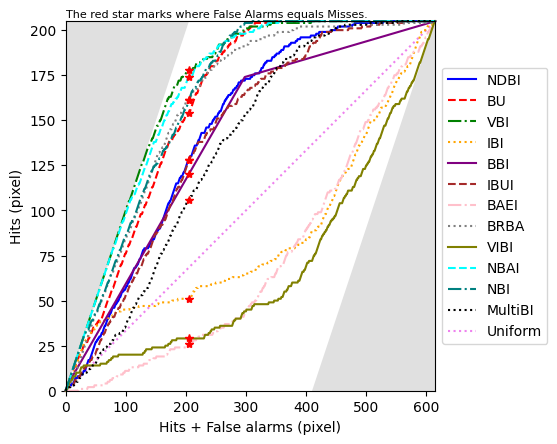

In [65]:
# ✅ Assuming you already have your 13 TOC objects created:
TOC_list = [TOC_NDBI, TOC_BU, TOC_VBI, TOC_IBI, TOC_BBI, TOC_IBUI, TOC_BAEI, 
            TOC_BRBA, TOC_VIBI, TOC_NBAI, TOC_NBI, TOC_MultiBI]

# ✅ Corresponding names for the legend
index_names = ["NDBI", "BU", "VBI", "IBI", "BBI", "IBUI", 
               "BAEI", "BRBA", "VIBI", "NBAI", "NBI", "MultiBI"]

# 🎨 Colors (you can modify as you like)
color_list = [
    'blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 
    'gray', 'olive', 'cyan', 'teal', 'black'
]

# # 🎨 Different markers for variety
# marker_list = [
#     'o', 's', '^', 'D', 'v', 'p', '*', 
#     'h', 'H', 'X', '<', '>', '+'
# ]

# # 🎨 Line styles (cycled)
line_list = ['-', '--', '-.', ':'] * 4  # repeats for all indices

# ✅ Create TOC_painter instance
toc_painter = TOC_painter(
    TOC_list=TOC_list,
    index_names=index_names,
    color_list=color_list,
    # marker_list=marker_list,
    line_list=line_list,
    boolUniform=True,
    boolCorrectCorner=True
)

# ✅ Add the "all correct" corner line (optional)
plt.xlabel('Hits + False alarms (pixel)')
plt.ylabel('Hits (pixel)')
toc_painter.add_all_correct_corner()

# ✅ Paint TOC plot
toc_painter.paint()

# ✅ Close any extra figure TOC_painter might have created
# plt.close()

# # ✅ Make sure all plotted lines are thin
# for line in plt.gca().get_lines():
#     line.set_linewidth(1)

# # ✅ Final plot styling
# plt.xlabel('Hits + False alarms (pixel)', fontsize=12)
# plt.ylabel('Hits (pixel)', fontsize=12)
# plt.legend(index_names, loc='lower right', fontsize=9)
# plt.tight_layout()

# # ✅ Show only ONE clean plot
# plt.show()


In [66]:
# Open the saved image and convert it to grayscale
img = Image.open("pic/Figure10.jpg").convert("L")
img.save("pic/Figure10_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure10_greyscale.jpg")  # Overwrite with grayscale version

# Boxplot Generation

In [41]:
# generate the boxplot and the 2 SD difference plot
Index_boxplot = all_csv
Index_boxplot['Type'].replace(1, "White", inplace=True)
Index_boxplot['Type'].replace(2, "Red", inplace=True)
Index_boxplot['Type'].replace(3, "Other", inplace=True)
Index_boxplot['Type'].replace(4, "Road", inplace=True)
Index_boxplot['Type'].replace(6, "Ground", inplace=True)
Index_boxplot['Type'].replace(7, "Vegetation", inplace=True)
Index_boxplot['Type'].replace(8, "Water", inplace=True)
Index_boxplot['Type'].replace(9, "Soil", inplace=True)

Index_boxplot['Urban'].replace(0, "Non-Built-up", inplace=True)
Index_boxplot['Urban'].replace(1, "Built-up", inplace=True)

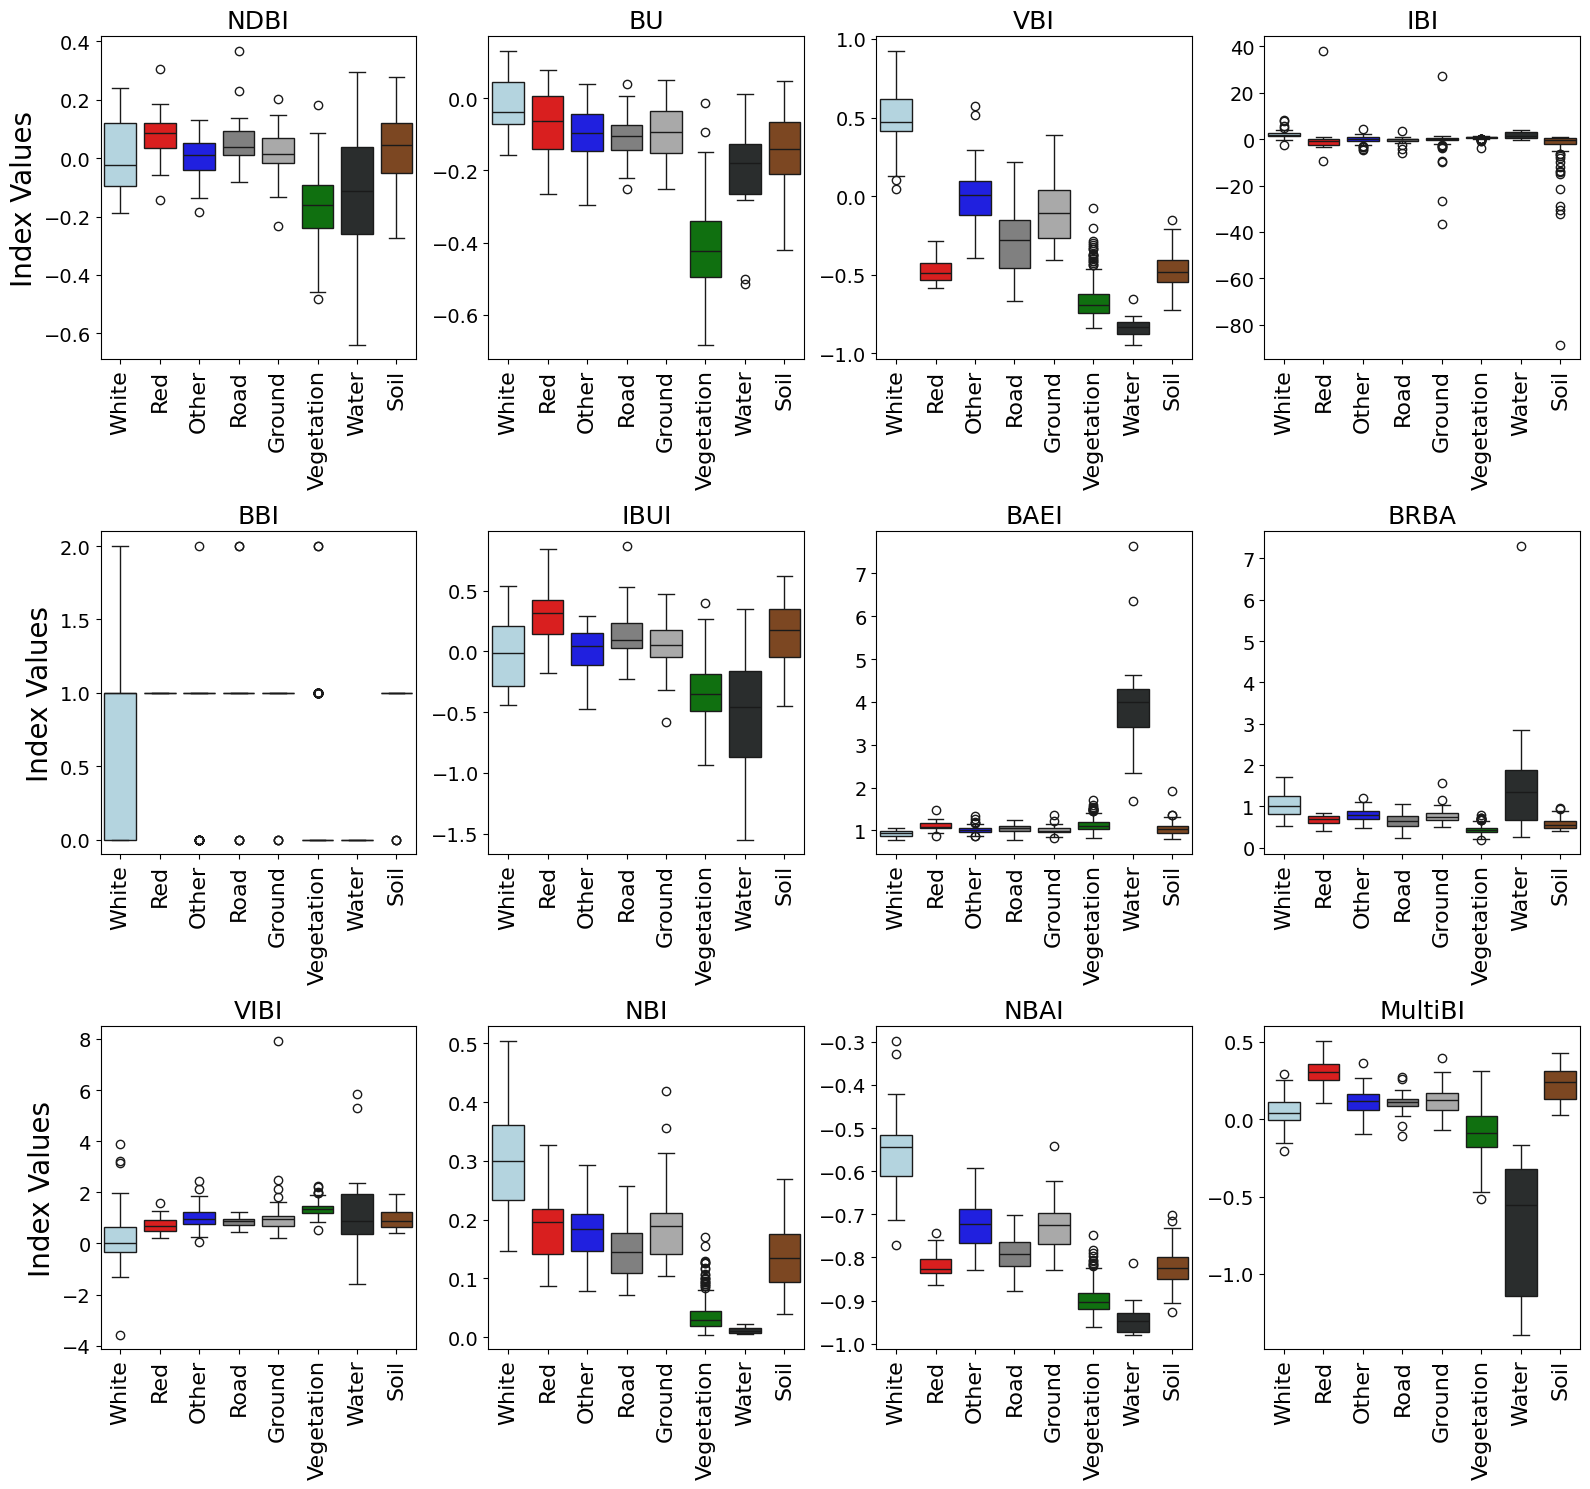

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Existing palette and order
palette = {
    'White': '#ADD8E6', 'Red': '#F80000', 'Other': '#0000FF',  
    'Road': '#808080', 'Ground': '#A9A9A9', 'Vegetation': '#008000', 
    'Water': '#2a2d2d', 'Soil': '#8B4513'
}
bp_order = ['White', 'Red', 'Other', 'Road', 'Ground', 'Vegetation', 'Water', 'Soil']

# All indices wanted to plot
indices = ["NDBI", "BU", "VBI", "IBI", "BBI", "IBUI", "BAEI", 
           "BRBA", "VIBI", "NBI", "NBAI", "MultiBI"]

# Font sizes
axis_fontsize = 20  
title_fontsize = 18  
tick_fontsize = 14  

# Create subplots automatically sized
n_indices = len(indices)
n_cols = 4  # You can adjust to 3 or 4 columns depending on space
n_rows = (n_indices + n_cols - 1) // n_cols  # auto calculate rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each index in a loop
for i, index in enumerate(indices):
    sns.boxplot(
        ax=axes[i], 
        x='Type', 
        y=index, 
        data=Index_boxplot, 
        palette=palette, 
        order=bp_order
    )
    axes[i]
    axes[i].set_title(index, fontsize=title_fontsize)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Index Values' if i % n_cols == 0 else '', fontsize=axis_fontsize)
    axes[i].tick_params(axis='x', labelrotation=90, labelsize=16)
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)

# Turn off any unused axes (if 13 plots don’t fill grid perfectly)
for j in range(len(indices), len(axes)):
    axes[j].axis('off')

# Layout & save
plt.tight_layout()
# plt.savefig("pic/All_Indices_Boxplots.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
# plt.savefig("pic/All_Indices_Boxplots.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()


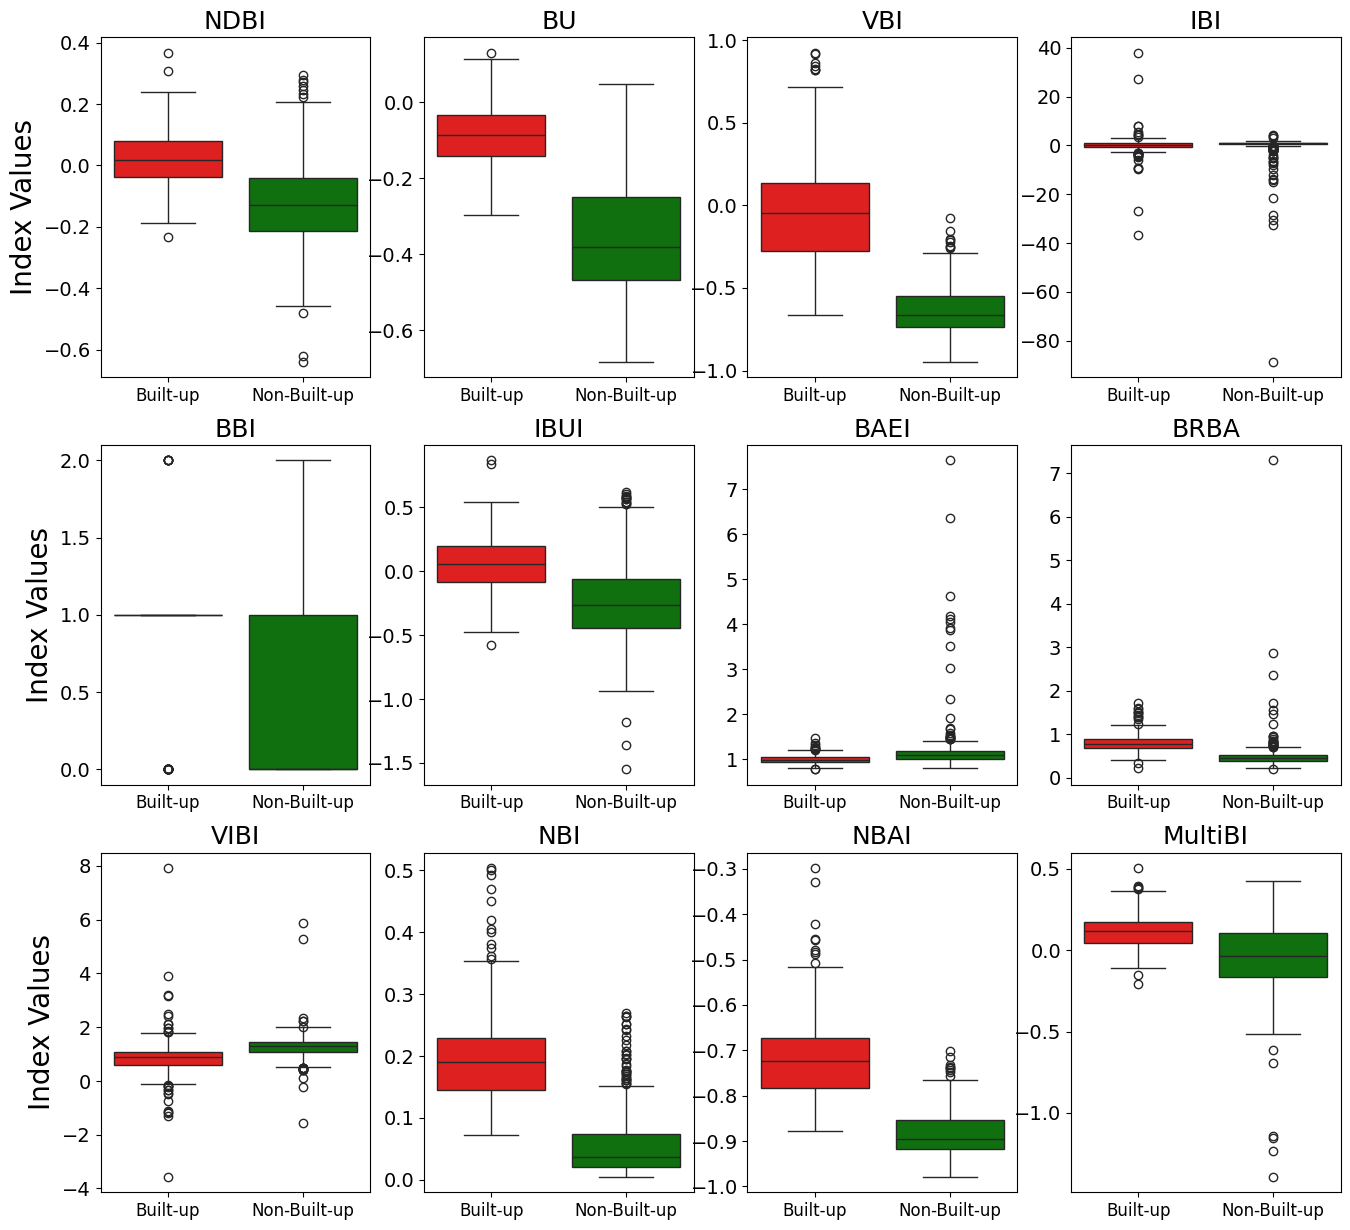

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Existing palette and order
palette = {'Built-up': 'red', 'Non-Built-up': 'green'}
bp_order = ['Built-up', 'Non-Built-up']

# All indices wanted to plot
indices = ["NDBI", "BU", "VBI", "IBI", "BBI", "IBUI", "BAEI", 
           "BRBA", "VIBI", "NBI", "NBAI", "MultiBI"]

# Font sizes
axis_fontsize = 20  
title_fontsize = 18  
tick_fontsize = 14  

# Create subplots automatically sized
n_indices = len(indices)
n_cols = 4  # You can adjust to 3 or 4 columns depending on space
n_rows = (n_indices + n_cols - 1) // n_cols  # auto calculate rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each index in a loop
for i, index in enumerate(indices):
    sns.boxplot(
        ax=axes[i], 
        x='Urban', 
        y=index, 
        data=Index_boxplot, 
        palette=palette, 
        order=bp_order
    )
    axes[i]
    axes[i].set_title(index, fontsize=title_fontsize)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Index Values' if i % n_cols == 0 else '', fontsize=axis_fontsize)
    axes[i].tick_params(axis='x', labelrotation=0, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=tick_fontsize)

# Turn off any unused axes (if 12 plots don’t fill grid perfectly)
for j in range(len(indices), len(axes)):
    axes[j].axis('off')

# Statistical Importance Analysis

In [58]:
# Desired order for rows & columns
all_csv = pd.read_csv(cwp + "/data/20250731_615_allbands_update.csv")
rename_dict = {
    1: "White",
    2: "Red",
    3: "Other",
    4: "Road",
    6: "Ground",
    7: "Vegetation",
    8: "Water",
    9: "Soil"
}
all_csv['Type'] = all_csv['Type'].map(rename_dict)
all_csv

,Urban,Type,CID,b2,b3,b4,b8,b11,hue,sat,...,MultiBI,IBI,IBUI,BRBA,BBI,BAEI,BU,VIBI,b12,NBAI
0,1,Other,0,0.1402,0.1632,0.1968,0.3300,0.3007,0.067727,0.287602,...,0.243401,0.396131,-0.015882,0.755470,1,1.070920,-0.149652,1.225090,0.2605,-0.752262
1,0,Soil,0,0.0624,0.0894,0.0998,0.3544,0.2026,0.120321,0.374750,...,0.091567,1.029110,-0.450288,0.720058,1,1.369178,-0.416539,1.946240,0.1386,-0.884731
2,1,Road,0,0.1256,0.1632,0.1522,0.3760,0.3200,0.215426,0.230392,...,-0.111717,1.009028,-0.223364,0.634960,0,0.935844,-0.252081,1.234410,0.2397,-0.782139
3,1,White,0,0.2866,0.3596,0.4584,0.4960,0.5432,0.070819,0.374782,...,0.124842,-2.530568,0.200265,0.860522,1,0.840053,0.003011,0.464493,0.5327,-0.478580
4,1,White,0,0.4444,0.4536,0.4504,0.4764,0.3434,0.224638,0.020282,...,-0.055141,1.957983,-0.421269,1.594900,0,0.941531,-0.095144,-0.209072,0.2824,-0.456638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,0,Vegetation,0,0.0608,0.0937,0.0987,0.3432,0.3060,0.144679,0.383992,...,0.169869,0.523057,-0.084595,0.455889,1,0.997498,-0.305297,1.115530,0.2165,-0.875655
611,0,Vegetation,0,0.0486,0.0809,0.0740,0.3672,0.2790,0.202270,0.399258,...,0.117993,0.775892,-0.246317,0.399568,0,1.039178,-0.400521,1.258470,0.1852,-0.898071
612,0,Soil,0,0.0581,0.0892,0.0860,0.4016,0.2709,0.183816,0.348655,...,0.100041,0.929327,-0.319255,0.439224,0,1.071924,-0.420801,1.429120,0.1958,-0.878866
613,0,Vegetation,0,0.0520,0.0817,0.0744,0.3044,0.3142,0.207632,0.363525,...,0.165965,0.333273,0.000026,0.362573,0,0.945693,-0.295669,0.974572,0.2052,-0.898691


In [59]:

# List of all 12 indices
indices = ["NDBI", "BU", "VBI", "IBI", "BBI", "IBUI", 
           "BAEI", "BRBA", "VIBI", "NBI", "NBAI", "MultiBI"]

mann_whitney_results = {}

# Loop through each index
for index in indices:
    # Split data into Urban vs Non-Urban for each index
    urban = all_csv[all_csv['Urban'] == 1][index]
    non_urban = all_csv[all_csv['Urban'] == 0][index]
    
    # Perform Mann–Whitney U test
    stat, p = stats.mannwhitneyu(urban, non_urban, alternative='two-sided')
    
    # Store results
    mann_whitney_results[index] = {
        "Statistic": stat,
        "P-value": p,
        "Conclusion": "Significant difference" if p < 0.05 else "No significant difference"
    }

# Print results neatly
for idx, res in mann_whitney_results.items():
    print(f"{idx}: U={res['Statistic']:.2f}, p={res['P-value']:.4f} → {res['Conclusion']}")



NDBI: U=67916.00, p=0.0000 → Significant difference
BU: U=76956.00, p=0.0000 → Significant difference
VBI: U=81542.00, p=0.0000 → Significant difference
IBI: U=31348.00, p=0.0000 → Significant difference
BBI: U=65183.00, p=0.0000 → Significant difference
IBUI: U=65777.00, p=0.0000 → Significant difference
BAEI: U=23117.00, p=0.0000 → Significant difference
BRBA: U=76825.00, p=0.0000 → Significant difference
VIBI: U=19902.00, p=0.0000 → Significant difference
NBI: U=78694.00, p=0.0000 → Significant difference
NBAI: U=80906.00, p=0.0000 → Significant difference
MultiBI: U=61672.50, p=0.0000 → Significant difference


In [60]:
# All 12 indices
indices = ["NDBI", "BU", "VBI", "IBI", "BBI", "IBUI", 
           "BAEI", "BRBA", "VIBI", "NBI", "NBAI", "MultiBI"]

kruskal_results = {}
dunn_results = {}

# Loop through each index
for idx in indices:
    # Get groups for Kruskal–Wallis (list of arrays for each land cover type)
    groups = [all_csv[all_csv['Type'] == t][idx].dropna() for t in all_csv['Type'].unique()]
    
    # 🏗 Kruskal–Wallis test
    kruskal_stat, p_value = stats.kruskal(*groups)
    
    # Store Kruskal–Wallis results
    kruskal_results[idx] = {
        "Kruskal-Wallis Statistic": kruskal_stat,
        "P-value": p_value,
        "Conclusion": "Significant difference among land cover types" if p_value < 0.05 else "No significant difference"
    }
    
    # If significant, run Dunn’s post-hoc
    if p_value < 0.05:
        dunn_df = sp.posthoc_dunn(all_csv, val_col=idx, group_col='Type', p_adjust='bonferroni')
        dunn_results[idx] = dunn_df  # store the full Dunn’s matrix

# Convert Kruskal results into DataFrame for easy viewing/export
kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient='index')
print("\n📊 Kruskal-Wallis Summary:")
print(kruskal_df)

# # Print Dunn’s matrices for significant indices
# for idx, df in dunn_results.items():
#     print(f"\n🔎 Dunn's Post-Hoc Results for {idx} (Bonferroni corrected):")
#     print(df)



📊 Kruskal-Wallis Summary:
         Kruskal-Wallis Statistic       P-value  \
NDBI                   310.705321  3.125483e-63   
BU                     431.603740  3.954006e-89   
VBI                    466.058457  1.578723e-96   
IBI                    245.521581  2.486572e-49   
BBI                    359.024489  1.440583e-73   
IBUI                   307.980049  1.194536e-62   
BAEI                   167.405068  8.845657e-33   
BRBA                   381.443611  2.268282e-78   
VIBI                   213.729958  1.411966e-42   
NBI                    458.226060  7.599194e-95   
NBAI                   459.088611  4.960207e-95   
MultiBI                348.489257  2.594666e-71   

                                            Conclusion  
NDBI     Significant difference among land cover types  
BU       Significant difference among land cover types  
VBI      Significant difference among land cover types  
IBI      Significant difference among land cover types  
BBI      Significant dif

In [61]:
# Print Dunn’s matrices for significant indices


# for idx, df in dunn_results.items():
#     print(f"\n🔎 Dunn's Post-Hoc Results for {idx} (Bonferroni corrected):")
#     print(df)


order = ["White", "Red", "Other", "Road", "Ground", "Vegetation", "Water", "Soil"]

# New dictionary to store processed matrices
triangular_results = {}

# Loop through all Dunn’s test results
for index_name, df in dunn_results.items():
    # Reorder the matrix before masking
    df_reordered = df.reindex(index=order, columns=order)

    # Convert to lower triangular
    triangular_df = make_lower_triangular(df_reordered)
    
    # Store result
    triangular_results[index_name] = triangular_df

# Check one result
print(triangular_results['NDBI'])

                   White           Red         Other          Road  \
White       1.000000e+00           NaN           NaN           NaN   
Red         1.000000e+00  1.000000e+00           NaN           NaN   
Other       1.000000e+00  1.000000e+00  1.000000e+00           NaN   
Road        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
Ground      1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
Vegetation  5.012844e-11  1.351353e-10  1.489123e-22  6.038058e-16   
Water       6.541807e-01  2.601040e-02  1.591056e-01  1.737869e-02   
Soil        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  Ground    Vegetation     Water  Soil  
White                NaN           NaN       NaN   NaN  
Red                  NaN           NaN       NaN   NaN  
Other                NaN           NaN       NaN   NaN  
Road                 NaN           NaN       NaN   NaN  
Ground      1.000000e+00           NaN       NaN   NaN  
Vegetation  4.068257e-18  1

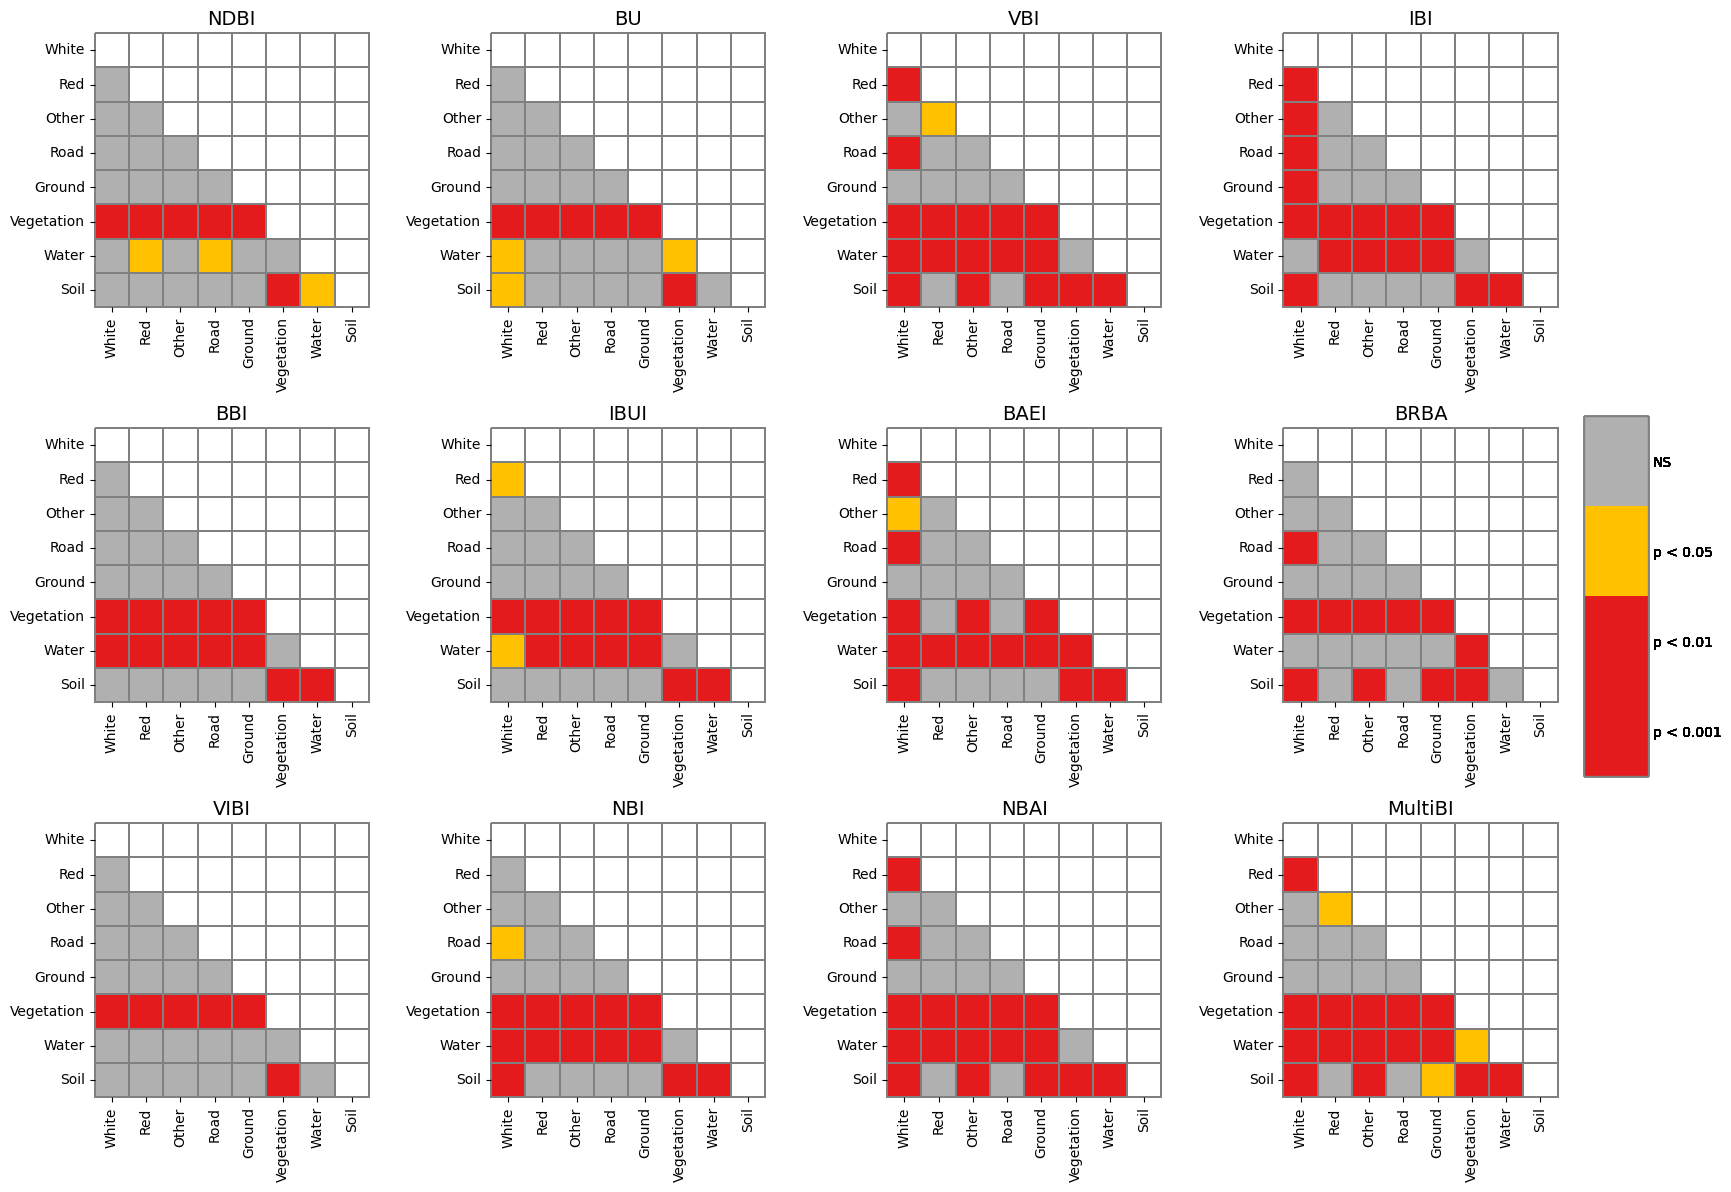

In [67]:
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# List of all indices
indices = ["VBI", "NDBI", "BU", "IBI", "BBI", "IBUI", 
           "BAEI", "BRBA", "VIBI", "NBI", "NBAI", "MultiBI"]

# Color map for significance plot
cmap = ['1', '#B0B0B0', '#E41A1C', '#E41A1C', '#ffc100']
heatmap_args = {
    'cmap': cmap,
    'linewidths': 0.25,
    'linecolor': '0.5',
    'clip_on': False,
    'square': True,
    'cbar_ax_bbox': [1, 0.35, 0.04, 0.3],
    'cbar_kws': {'shrink': 0.8, 'labelsize': 12}
}

# Create subplots: 13 indices → arrange in grid
n_cols = 4
n_rows = (len(indices) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  # flatten for easy iteration

# Plot each lower-triangular Dunn’s result
for i, (index_name, triangular_df) in enumerate(triangular_results.items()):
    sp.sign_plot(triangular_df, ax=axes[i], **heatmap_args)
    axes[i].set_title(index_name, fontsize=14)
    axes[i].tick_params(axis='x', labelsize=10, rotation=90)
    axes[i].tick_params(axis='y', labelsize=10)

# Turn off any extra blank subplot axes (since 16 slots > 13 plots)
for j in range(len(triangular_results), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("pic/Figure12.jpg", dpi=1200, format="jpeg", bbox_inches="tight")
plt.savefig("pic/Figure12.pdf", dpi=1200, format="pdf", bbox_inches="tight")
plt.show()


In [68]:
# Open the saved image and convert it to grayscale
Image.MAX_IMAGE_PIXELS = None
img = Image.open("pic/Figure12.jpg").convert("L")
img.save("pic/Figure12_greyscale.pdf")  # Overwrite with grayscale version
img.save("pic/Figure12_greyscale.jpg")  # Overwrite with grayscale version